<a href="https://colab.research.google.com/github/enriqueasegura/Exercises/blob/master/Bell_State_and_QML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
import numpy as np
!pip install git+https://github.com/quantumlib/Cirq
  
import matplotlib.pyplot as plt
from pandas import DataFrame
import cirq
from cirq.ops import CNOT, TOFFOLI
from cirq import Simulator
import random
from sympy import Symbol
from cirq.circuits import InsertStrategy
"""
! sudo apt-get install texlive-latex-recommended #1
! sudo apt-get install dvipng texlive-fonts-recommended #2
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
! unzip type1cm.zip -d /tmp/type1cm #4
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
! sudo texhash #8
"""
import matplotlib
from cirq.contrib.svg import SVGCircuit

!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf -P /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf

  Cloning https://github.com/quantumlib/Cirq to /tmp/pip-req-build-7aimxz8y
  Running command git clone -q https://github.com/quantumlib/Cirq /tmp/pip-req-build-7aimxz8y
  Created wheel for cirq: filename=cirq-0.8.0.dev0-cp36-none-any.whl size=1353934 sha256=cca05b4c8abd6b874650869a51977fc01bc466c077dd7d7a378e5a3740ecd541
  Stored in directory: /tmp/pip-ephem-wheel-cache-kkzsxgzo/wheels/c9/f4/ee/029123a49c5e2d75d08c2a9f937e207b88f045901db04632a7
Successfully built cirq
--2020-03-22 20:50:47--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2020-03-22 20:50:47--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
R

#Building a Bell State to illustrate the circuit we want to do 

1. We would like to build a circuit relying on the old fashion quantum circuit. 
2. We wil follow Chuang and Nielsen's book to develop this system. 

Resulting Circuit that brings one of the 
[cirq.LineQubit(0), cirq.LineQubit(1), cirq.LineQubit(2)]


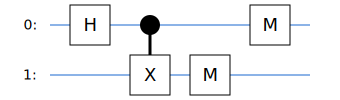

In [109]:
#let's build a simple Cirq circuit to make this bell state 

circuit = cirq.Circuit()

#defining number of physical qubits in the circuit
num_physical_qubits = 3

qubits = [ cirq.LineQubit(i) for i in range(num_physical_qubits)]

#building the bell state
circuit.append(cirq.H(qubits[0]))

circuit.append(cirq.CNOT(qubits[0], qubits[1]))

#This part is key: to measure not at the same time but in this sequence to get the new basis

circuit.append(cirq.measure(qubits[1]), strategy=InsertStrategy.EARLIEST)
circuit.append(cirq.measure(qubits[0]), strategy=InsertStrategy.NEW)

print('Resulting Circuit that brings one of the ')
print(qubits)

SVGCircuit(circuit)

This is the result we can to reach through optimization:


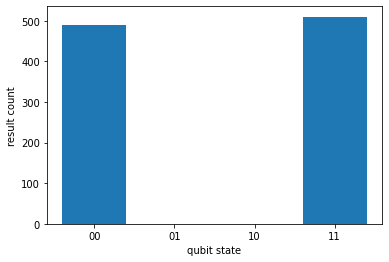

In [185]:
#call the simulator to conduct the measurement

simulator = cirq.Simulator()

#execute simulations

num_repetitions = 1000

results = simulator.run(circuit, repetitions=num_repetitions)
print('This is the result we can to reach through optimization:')
cirq.plot_state_histogram(results)

#Preserve the measurement values
s_k, s_v= zip(*results.measurements.items())

label_values = 1 - 2*np.array(s_v).astype(np.int32)

In [0]:
def test_decomp(num_physical_qubits, xparam, yparam):
  c = cirq.Circuit()
  q = [cirq.LineQubit(i) for i in range(num_physical_qubits)]

  xgate = cirq.XPowGate(exponent=xparam)
  ygate = cirq.YPowGate(exponent=yparam)

  c.append(xgate(q[0]))
  c.append(ygate(q[0]))

  c.append(cirq.CNOT(q[0], q[1]))

  c.append(cirq.measure(q[1]), strategy=InsertStrategy.EARLIEST)
  c.append(cirq.measure(q[0]), strategy=InsertStrategy.NEW)
  return c

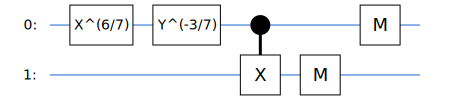

In [187]:
test_d = test_decomp(num_physical_qubits, -np.pi, np.pi/2)

SVGCircuit(test_d)

This is the result we can to reach through optimization:


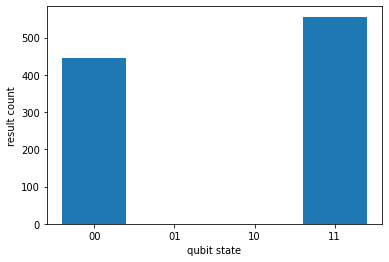

In [188]:
#call the simulator to conduct the measurement

simulator = cirq.Simulator()

#execute simulations

num_repetitions = 1000

results = simulator.run(test_d, repetitions=num_repetitions)
print('This is the result we can to reach through optimization:')
cirq.plot_state_histogram(results)

#Preserve the measurement values
s_k, s_v= zip(*results.measurements.items())

label_values = 1 - 2*np.array(s_v).astype(np.int32)

In [0]:
def h_decomposition(q,xparam, yparam):
  xgate = cirq.XPowGate(exponent=xparam)
  ygate = cirq.YPowGate(exponent=yparam)
  yield xgate(q)
  yield ygate(q)

In [0]:
#Our approach is borrowed from Farhi et al's paper
#Namely, to establish a way to extract the quantum state label and
#use sgd to get it
#so first, build the boiler-plate bell state 

def hadamard_bell_state(num_qubits, xparam, yparam):
  c = cirq.Circuit()
  q = [cirq.LineQubit(i) for i in range(num_physical_qubits)]

  xgate = cirq.XPowGate(exponent=xparam)
  ygate = cirq.YPowGate(exponent=yparam)

  c.append(cirq.Y(q[2]))

  c.append(xgate(q[0]))
  c.append(cirq.CNOT(q[0], q[2]))
  c.append(ygate(q[0]))
  c.append(cirq.CNOT(q[0], q[2]))

  c.append(cirq.CNOT(q[0], q[1]))
  c.append(cirq.CNOT(q[0], q[2]))
  c.append(cirq.CNOT(q[1], q[2]))

  c.append(cirq.Y(q[2]))

  c.append(cirq.measure(q[2], key='q0'))



  return c

  



In [0]:
xfactor, yfactor = np.random.uniform(0,2*np.pi),np.random.uniform(0,2*np.pi)


In [0]:
t = hadamard_bell_state(num_physical_qubits, xfactor, yfactor)

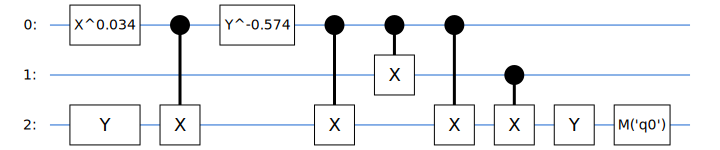

In [322]:
SVGCircuit(t)

This is the result when dealing with ideal case:


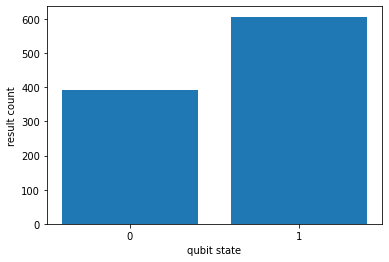

In [323]:
#Now, let's calculate the values regarding current label at the ideal case and the loss function at that case

#call the simulator to conduct the measurement

t_simulator = cirq.Simulator()

#execute simulations

num_repetitions = 1000

t_results = simulator.run(t, repetitions=num_repetitions)
print('This is the result when dealing with ideal case:')
cirq.plot_state_histogram(t_results)

#Preserve the measurement values
s_k, s_v= zip(*t_results.measurements.items())
label_values = 1 - 2*np.array(s_v).astype(np.int32)

In [324]:
current_predicted_label_value = np.mean(label_values)
print('current pred label: ', current_predicted_label_value )
  
current_loss_value = 1 - np.square(current_predicted_label_value)
print('current loss: ', current_loss_value)

current pred label:  -0.214
current loss:  0.954204


In [0]:
def SGD_BC(num_physical_qubits, xparam, yparam, num_reps, adam_toggle):
  #this list keeps a record of the evolution of phi as optimization searches for
  #loss minimum. 
  weight_arr_x = []
  weight_arr_y = []
  
  #this list keeps track of the loss function as it is being minimized.
  loss_arr =[]
  
  grad_arr =[]
  label_arr =[]
  
  zero_state_arr =[]
  one_state_arr =[]
  
  delta_theta = []
  
  status = 'not done'
  count = 0
  
  #code to implement Learning Rate Optimization
  #We used OpenAI's Adam paper as a reference.
  
  #gradient_moment = 0 
  #momentum_moment =0
  
  beta_1 = 0.9
  beta_2 = 0.999
  smoothing_epsilon = 1e-10
  learning_rate = 0.001

  first_gradient_moment = 0
  second_gradient_moment = 0

  first_gradient_moment_arr = []
  second_gradient_moment_arr = []

  first_gradient_moment_arr.append(first_gradient_moment)
  second_gradient_moment_arr.append(second_gradient_moment)
  count = 0

  while status == 'not done':
    #get results
    
    weight_arr_y.append(yparam)
    weight_arr_x.append(xparam)

    #print('current count: ', count)
    #print('current yparam:', yparam)
    
    test_circuit = hadamard_bell_state(num_physical_qubits, xparam, yparam)
    
    test_results = simulator.run(test_circuit, repetitions=num_reps)
    
    count_results = test_results.histogram(key='q0')
    
    #normalizing state population by repetition value
    zero_state_arr.append(count_results[0]/num_reps)
    one_state_arr.append(count_results[1]/num_reps)
    
    s_k, s_v= zip(*test_results.measurements.items())
  
    current_state_values = 1-2*np.array(s_v).astype(np.int32)

    current_predicted_label_value = np.mean(current_state_values)
    #print('current pred label: ', current_predicted_label_value )
    label_arr.append(current_predicted_label_value)
  
    current_loss_value = 1 - np.square(current_predicted_label_value)
    loss_arr.append(current_loss_value)
    
    current_gradient_value = 2*current_predicted_label_value
    
    current_grad_square = np.square(current_gradient_value)
    
    #target_loss_value =  .9999
    #target_difference = target_loss_value - current_loss_value
    #diff_arr.append(target_difference)
    print('current count: ', count, 'current loss: ', current_loss_value)

    
    if count > 4000: 
      print('count is way too much!')
      status = 'done'
      break
    
    elif np.absolute(current_loss_value) < 1e-5:
    #elif np.absolute(target_difference) < 1e-3:
      status = 'done'
      print('Done! Final Weight: ', weight_arr_x[-1])
      print('Done! Final Weight: ',weight_arr_y[-1])
      cirq.plot_state_histogram(test_results)   

    elif adam_toggle == 'on':
      curr_gradient_value = current_loss_value
      #This code updates the moment vector's parameters. 
      next_first_gradient_moment = beta_1 * first_gradient_moment_arr[count] + (1 - beta_1) * curr_gradient_value
      first_gradient_moment_arr.append(next_first_gradient_moment)

      next_second_gradient_moment = beta_2 * second_gradient_moment_arr[count] + (1 - beta_2) * np.square(curr_gradient_value)
      second_gradient_moment_arr.append(next_second_gradient_moment)

      bias_corrected_first_moment = np.divide(first_gradient_moment_arr[count], 1 - np.power(beta_1, count+1))
      bias_corrected_second_moment = np.divide(second_gradient_moment_arr[count], 1 - np.power(beta_2, count+1))
      
      #adjust the weights to find optimal parameters 
      xparam -= learning_rate * np.divide(bias_corrected_first_moment , (np.sqrt(bias_corrected_second_moment) + smoothing_epsilon))
      yparam -= learning_rate * np.divide(bias_corrected_first_moment , (np.sqrt(bias_corrected_second_moment) + smoothing_epsilon))
      count+=1
      

    else:
      yparam -= learning_rate*current_loss_value
      xparam -= learning_rate*current_loss_value
      count+=1

  return(weight_arr_x, weight_arr_y,loss_arr, weight_arr_x[-1],weight_arr_y[-1], label_arr, zero_state_arr, one_state_arr)


current random y parameter:  4.034018666207925 5.426391250692007
current count:  0 current loss:  0.954204
current count:  1 current loss:  0.948016
current count:  2 current loss:  0.9471
current count:  3 current loss:  0.939484
current count:  4 current loss:  0.931356
current count:  5 current loss:  0.948924
current count:  6 current loss:  0.952476
current count:  7 current loss:  0.9471
current count:  8 current loss:  0.948016
current count:  9 current loss:  0.939484
current count:  10 current loss:  0.948924
current count:  11 current loss:  0.911196
current count:  12 current loss:  0.928176
current count:  13 current loss:  0.934464
current count:  14 current loss:  0.933436
current count:  15 current loss:  0.9039
current count:  16 current loss:  0.914736
current count:  17 current loss:  0.917056
current count:  18 current loss:  0.908796
current count:  19 current loss:  0.924924
current count:  20 current loss:  0.913564
current count:  21 current loss:  0.918204
curre

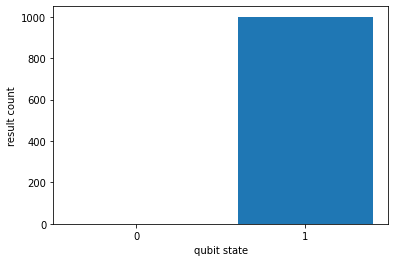

In [326]:
print('current random y parameter: ', xfactor, yfactor)
print('======')
num_repetitions = 1000
test_sgd = SGD_BC(num_physical_qubits, xfactor, yfactor, num_repetitions, 'off')

current count:  0 current loss:  0.936496
current count:  1 current loss:  0.956736
current count:  2 current loss:  0.9516
current count:  3 current loss:  0.956736
current count:  4 current loss:  0.965404
current count:  5 current loss:  0.930304
current count:  6 current loss:  0.935484
current count:  7 current loss:  0.9471
current count:  8 current loss:  0.949824
current count:  9 current loss:  0.929244
current count:  10 current loss:  0.935484
current count:  11 current loss:  0.924924
current count:  12 current loss:  0.940464
current count:  13 current loss:  0.933436
current count:  14 current loss:  0.933436
current count:  15 current loss:  0.9271
current count:  16 current loss:  0.913564
current count:  17 current loss:  0.908796
current count:  18 current loss:  0.902656
current count:  19 current loss:  0.9204760000000001
current count:  20 current loss:  0.926016
current count:  21 current loss:  0.8844
current count:  22 current loss:  0.9216
current count:  23 cu

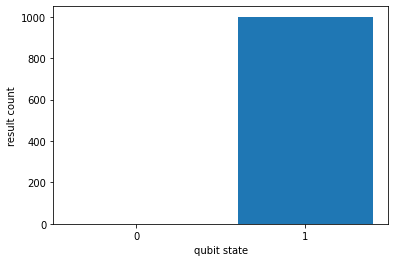

In [327]:
test_adam = SGD_BC(num_physical_qubits, xfactor, yfactor, num_repetitions, 'on')

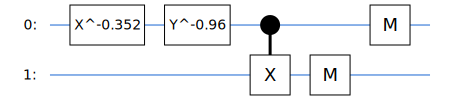

In [328]:
test_r = test_decomp(num_physical_qubits, test_adam[3], test_adam[4])

SVGCircuit(test_r)

This is the result when dealing with ideal case:


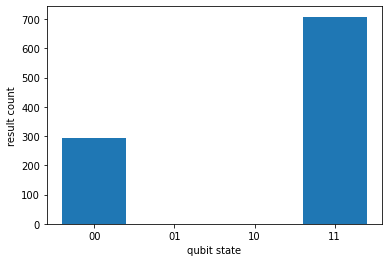

In [329]:
#Now, let's calculate the values regarding current label at the ideal case and the loss function at that case

#call the simulator to conduct the measurement

t_simulator = cirq.Simulator()

#execute simulations

num_repetitions = 1000

t_results = simulator.run(test_r, repetitions=num_repetitions)
print('This is the result when dealing with ideal case:')
cirq.plot_state_histogram(t_results)

#Preserve the measurement values
s_k, s_v= zip(*t_results.measurements.items())
label_values = 1 - 2*np.array(s_v).astype(np.int32)

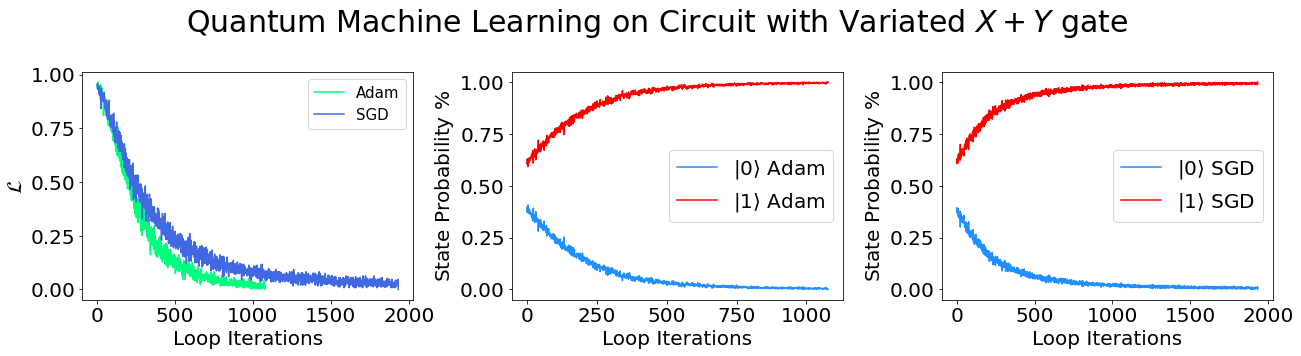

In [331]:
plt.figure(figsize=(18,5))
plt.subplot(131)
plt.tick_params(labelsize=20)
plt.plot(test_adam[2], color='springgreen', linestyle='-', label='Adam')
plt.plot(test_sgd[2], label='SGD', linestyle='-',color='royalblue')
plt.ylabel(r'$\mathcal{L}$', fontsize=20)
plt.xlabel('Loop Iterations', fontsize=20)

plt.legend(fontsize=15, loc='best')

plt.subplot(132)

plt.plot(test_adam[6], label = r'$|0 \rangle$ Adam', linestyle='-',color='dodgerblue') 
plt.plot( test_adam[7], label = r'$|1 \rangle$ Adam', linestyle='-', color='red')

plt.legend(loc='best', fontsize=20)
plt.tick_params(labelsize=20)

plt.xlabel('Loop Iterations', fontsize=20)
plt.ylabel(r'State Probability $\%$', fontsize=20)

plt.subplot(133)

plt.plot(test_sgd[6], label = r'$|0 \rangle$ SGD', linestyle='-',color='dodgerblue') 
plt.plot( test_sgd[7], label = r'$|1 \rangle$ SGD', linestyle='-', color='red')

plt.legend(loc='best', fontsize=20)
plt.tick_params(labelsize=20)

plt.xlabel('Loop Iterations', fontsize=20)
plt.ylabel(r'State Probability $\%$', fontsize=20)


plt.suptitle(r'Quantum Machine Learning on Circuit with Variated $X + Y$ gate', fontsize=30)
plt.tick_params(labelsize=20)

plt.tight_layout()

plt.subplots_adjust(top=.8)